# **基于霍夫变换的车道线检测**

**姓名：** [折浩宇]  
**学号：** [2023217896]  
**日期：** 2025年12月23日


完整的流程如下：

1.  **图像预处理**：加载并调整图像大小。
2.  **颜色与形态学提取**：使用严格的颜色阈值和形态学操作提取干净的车道线二值图像 (`clean_mask`)。
3.  **边缘检测**：对 `clean_mask` 应用 Canny 算子，精确提取边缘。
4.  **ROI 裁剪**：定义一个梯形区域，屏蔽掉图像中与车道无关的部分，如天空和道路两旁的景物。
5.  **霍夫变换**：在经过 ROI 裁剪后的边缘图像上执行霍夫变换，高效地检测直线。
6.  **结果可视化**：将检测到的车道线绘制回原图，并提供霍夫空间的可视化。


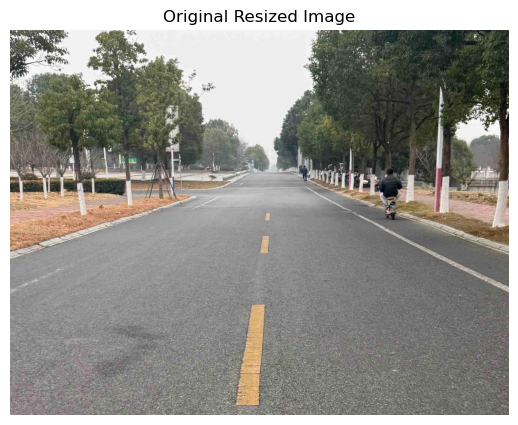

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 读取并 Resize ---
# 读取图像，注意：请确保 'campus_road4.jpg' 文件与你的 Notebook 在同一目录下
# 如果不在，请提供完整路径
try:
    image = cv2.imread('campus_road4.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Matplotlib 显示需要转为 RGB
except FileNotFoundError:
    print("错误：未找到 'campus_road4.jpg' 文件！")
    print("请创建一个同尺寸的黑色图像作为替代，以便后续代码可以运行。")
    image = np.zeros((600, 960, 3), dtype=np.uint8)


# 设定目标宽度，并按比例缩放图像
target_width = 960
aspect_ratio = image.shape[0] / image.shape[1]
target_height = int(target_width * aspect_ratio)
image = cv2.resize(image, (target_width, target_height))

# 显示原始图像
plt.figure(figsize=(8, 5))
plt.imshow(image)
plt.title('Original Resized Image')
plt.axis('off') # 不显示坐标轴
plt.show()

## **步骤 A & B: 优化的颜色提取与形态学去噪**

这是整个流程中最关键的一步。传统方法通常直接对灰度图进行处理，很容易受到光照变化和路面噪声（如裂缝、碎石）的干扰。

我的优化方案 `optimized_lane_extraction` 包含两个核心思想：

1.  **精确颜色阈值**：
    *   **黄色车道线**：在 **HSV** 色彩空间中提取。HSV 对光照强度变化不敏感，非常适合提取黄色。
    *   H（色相）：15~40（对应黄色区间）；
    *    S（饱和度）：50~255（提高饱和度阈值，过滤掉路面泛白的低饱和度区域）；
    *    V（明度）：50~255。
    *   **白色车道线**：在 **HLS** 色彩空间中提取。我们利用 **L (Lightness) 通道**，并设置一个非常高的阈值（`190`），这样可以有效地区分高亮度的白色车道线和相对较暗的灰色路面，即使在阴天路面泛白的情况下也能很好地工作。
    *   H（色相）：0~255（白色对色相不敏感，全范围）；
    *    L（亮度）：166~255（关键阈值！路面泛白的亮度约 130~160，白线亮度≥200，设为 166 可过滤掉大部分路面，只保留高亮的白线）；
    *     S（饱和度）：0~255（白色饱和度低，全范围）。

2.  **形态学去噪**：
    *   通过颜色筛选后，可能仍存在一些符合颜色特征的噪点（比如路边的白色小石头）。
    *   我们先使用 **腐蚀 (Erode)** 操作来“消除”这些孤立的、细小的噪点。
    *   然后使用 **膨胀 (Dilate)** 操作，将刚刚被腐蚀过的、真正属于车道线的部分恢复其原有的粗细，甚至让断裂的线段连接起来。

通过这个函数，我们能得到一个非常干净、噪声极少的二值图像（`clean_mask`），为后续的边缘检测和霍夫变换打下坚实的基础。


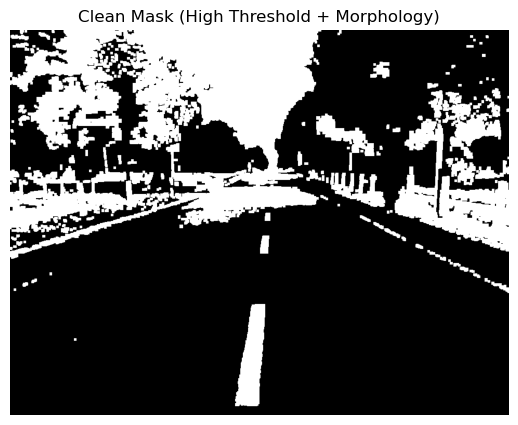

In [ ]:
def optimized_lane_extraction(img):
    """
    针对阴天/高亮度路面的究极提取方案
    """
    # --- A. 颜色提取 (严卡阈值) ---
    
    # 1. 黄色 (HSV): 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([15, 50, 50])  # Saturation 稍微提高，避开泛白的马路
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # 2. 白色 (HLS): 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # L 通道：马路大约是 130-160，白线大约是 200+
    # 所以我们设为 190，坚决过滤掉马路
    lower_white = np.array([0, 166, 0]) 
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    
    # 3. 合并颜色
    color_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    # --- B. 形态学去噪 (关键步骤) ---
    # 这一步专门对付那些通过了颜色筛选的碎石子噪点
    kernel = np.ones((3, 3), np.uint8)
    
    # "腐蚀"：吃掉孤立的噪点
    eroded = cv2.erode(color_mask, kernel, iterations=1)
    # "膨胀"：把剩下的车道线复原变粗
    dilated = cv2.dilate(eroded, kernel, iterations=2)
    
    return dilated

# 获取干净的 Mask
clean_mask = optimized_lane_extraction(image)

# 可视化 clean_mask
plt.figure(figsize=(8, 5))
plt.imshow(clean_mask, cmap='gray')
plt.title('Clean Mask (High Threshold + Morphology)')
plt.axis('off')
plt.show()

## **步骤 C & D: Canny 边缘检测与 ROI 裁剪**

1.  **Canny 边缘检测**：
    *   我们在上一步得到的 `clean_mask` 上执行 Canny 边缘检测。因为 `clean_mask` 已经非常干净，所以 Canny 的结果会非常精确，基本只包含车道线的边缘。

2.  **ROI (Region of Interest) 裁剪**：
    *   摄像头的视野中通常包含天空、树木、建筑物等与车道线无关的区域。为了提高计算效率和准确性，我们定义一个梯形的“感兴趣区域”，只保留图像中可能出现车道线的部分（通常是图像的下半部分）。
    *   我们将 Canny 边缘检测的结果与这个 ROI 区域进行按位与操作，得到最终用于霍夫变换的 `roi_edges`。


图像尺寸: 宽度=960, 高度=742


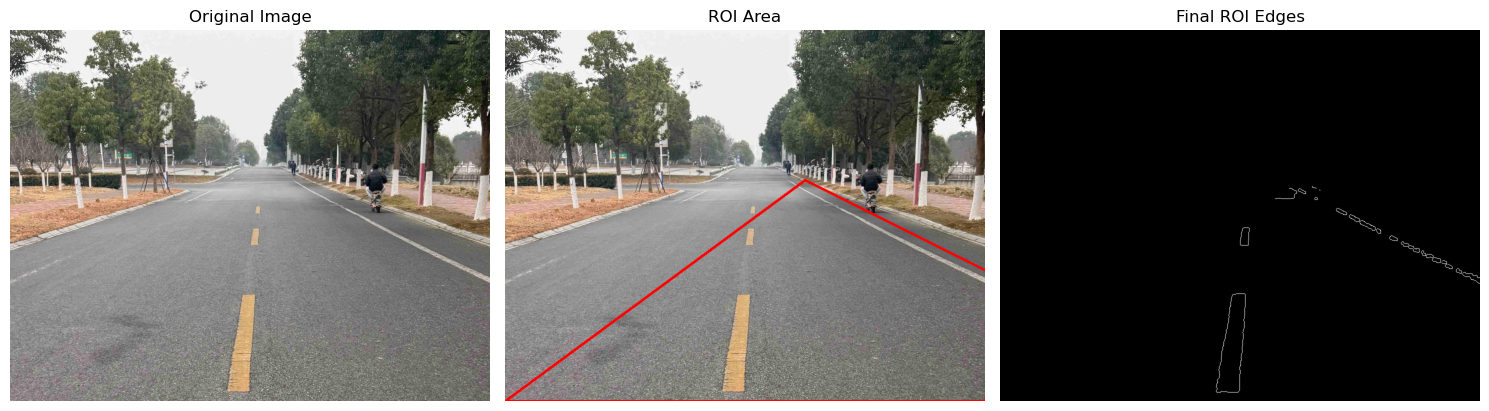

In [42]:
# C. 边缘检测
# 直接对干净的 Mask 做 Canny
edges = cv2.Canny(clean_mask, 50, 150)

# D. 定义 ROI 裁剪函数
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# 获取图像的高度和宽度，方便参考
h, w = image.shape[:2]
print(f"图像尺寸: 宽度={w}, 高度={h}")

# 设定四个顶点的坐标 (x, y)
# 你需要修改下面这四个点的数值
# 提示：通常，底部的两个点会贴着图像的底边。关键是调整上面两个点的位置来匹配车道的消失点。
bottom_left = (0, h)          # 点1: 图像左下角
bottom_right = (w, h)         # 点2: 图像右下角
top_right = (1000, 500)        # 点3: 梯形右上角 (需要你根据图像调整)
top_left = (600, 300)       # 点4: 梯形左上角 (需要你根据图像调整)

vertices = np.array([
    [bottom_left, bottom_right, top_right, top_left]
], dtype=np.int32)

roi_edges = region_of_interest(edges, vertices)

# --- 调试可视化 ---
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
# 画出 ROI 区域方便观察
roi_visualization = image.copy()
cv2.polylines(roi_visualization, vertices, isClosed=True, color=(255, 0, 0), thickness=3)
plt.imshow(roi_visualization)
plt.title("ROI Area")
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(roi_edges, cmap='gray')
plt.title("Final ROI Edges")
plt.axis('off')

plt.tight_layout()
plt.show()

## **步骤 E: 霍夫变换与霍夫空间可视化**

**霍夫变换 (Hough Transform)** 是一种在图像中寻找直线、圆形等特定形状的特征提取技术。其基本原理是将图像空间中的一个点，映射到参数空间（霍夫空间）中的一条线上。反之，图像空间中一条线上的所有点，在霍夫空间中会交于一点。

*   对于直线检测，我们使用极坐标 `(ρ, θ)` 来表示一条线。
    *   `ρ` (rho) 是原点到直线的垂直距离。
    *   `θ` (theta) 是这条垂直线与 x 轴的夹角。
*   当霍夫变换在 `(ρ, θ)` 空间中找到一个交点（累加计数值很高）时，就意味着在原始图像空间中发现了一条直线。

**霍夫空间可视化**:
下面的代码将展示霍夫空间的累加器图像。图中的每一个亮点都代表一个潜在的直线。最亮的点对应于图像中最显著的直线。这有助于我们理解霍夫变换是如何“投票”选出直线的。


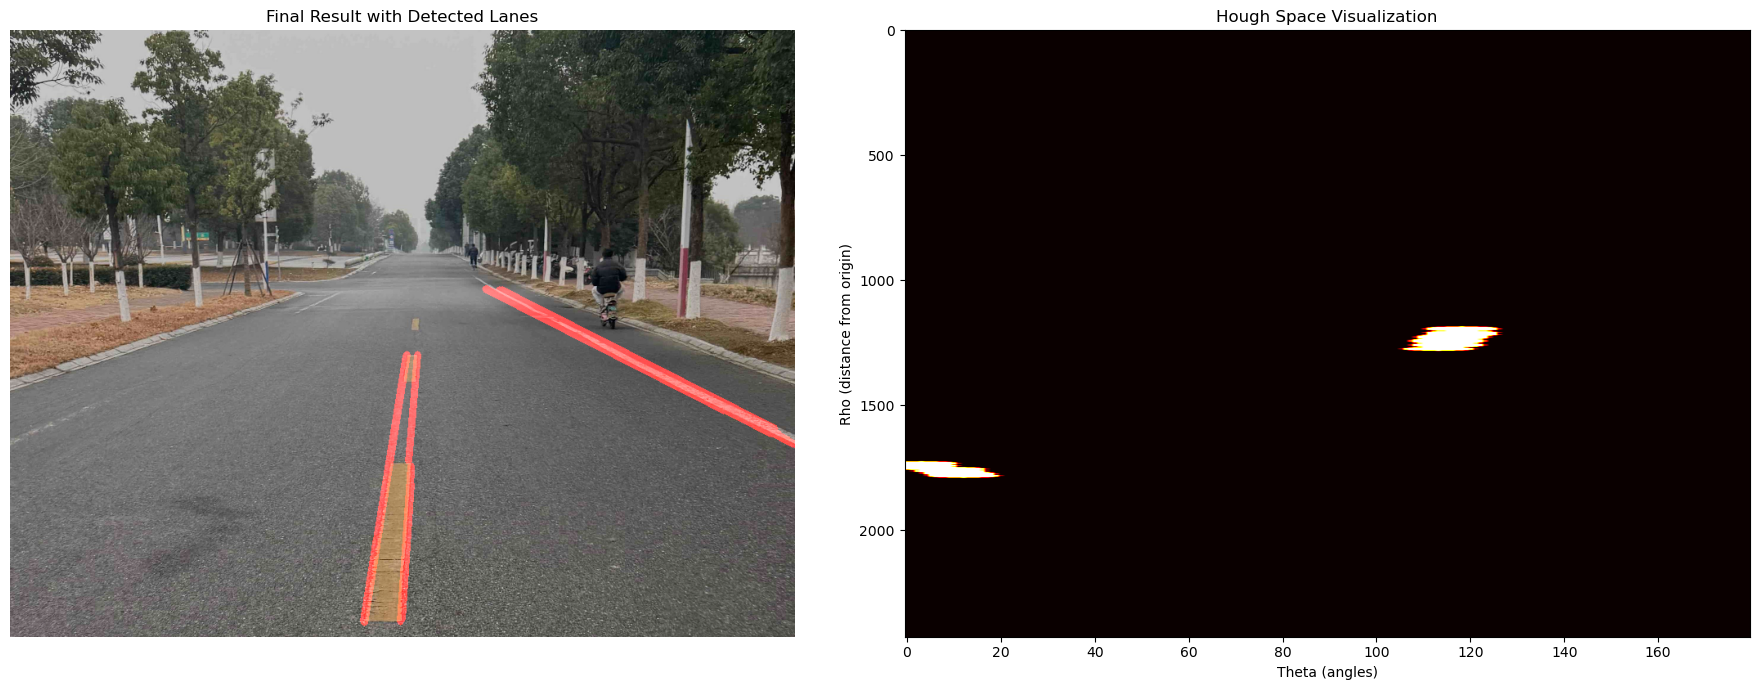

In [44]:
# --- 霍夫变换 ---
# 这一部分保持不变
lines = cv2.HoughLinesP(roi_edges, 
                        rho=1,                
                        theta=np.pi/180,      
                        threshold=30,         
                        minLineLength=50,     
                        maxLineGap=150)       

# --- 绘制结果 ---
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

result_img = np.zeros_like(image)
if lines is not None:
    draw_lines(result_img, lines, thickness=8)
    final = cv2.addWeighted(image, 0.8, result_img, 1.0, 0.0)
else:
    print("在ROI区域内未检测到直线")
    final = image.copy()


# --- 霍夫空间可视化 ---
# 【关键修改】将这里的 threshold 从 100 降低到一个更合理的值，比如 50
# 这个值需要大于HoughLinesP的30，因为HoughLines对整条直线投票，得分会更高
hough_lines = cv2.HoughLines(roi_edges, 1, np.pi / 180, threshold=50) # <--- 修改这里！

# --- 最终结果展示 ---
plt.figure(figsize=(18, 7))

# 左图：最终结果
plt.subplot(1, 2, 1)
plt.imshow(final)
plt.title("Final Result with Detected Lanes")
plt.axis('off')

# 右图：霍夫空间
ax = plt.subplot(1, 2, 2)
if hough_lines is not None:
    # 成功检测到直线，现在可以绘制霍夫空间了
    # 这是一个简化的可视化，真实的累加器无法直接从OpenCV获取
    # 我们就在一张黑布上把检测到的(rho, theta)点画出来
    num_rhos = int(np.hypot(image.shape[0], image.shape[1]))
    accumulator = np.zeros((num_rhos * 2, 180), dtype=np.uint8)
    
    for i in range(len(hough_lines)):
        rho = int(hough_lines[i][0][0] + num_rhos)
        theta = int(hough_lines[i][0][1] * 180 / np.pi)
        cv2.circle(accumulator, (theta, rho), 8, (255, 255, 255), -1)

    ax.imshow(accumulator, cmap='hot', aspect='auto')
    ax.set_title("Hough Space Visualization")
    ax.set_xlabel('Theta (angles)')
    ax.set_ylabel('Rho (distance from origin)')
else:
    # 如果修改后仍然失败，会显示这个
    ax.text(0.5, 0.5, 'Still no lines detected for visualization.\nTry lowering the threshold further.', 
            ha='center', va='center', fontsize=12)
    ax.set_title("Hough Space Visualization")
    ax.axis('off')
    
plt.tight_layout()
plt.show()

### 手动设定并可视化 ROI 顶点



图像尺寸: 宽度=960, 高度=742


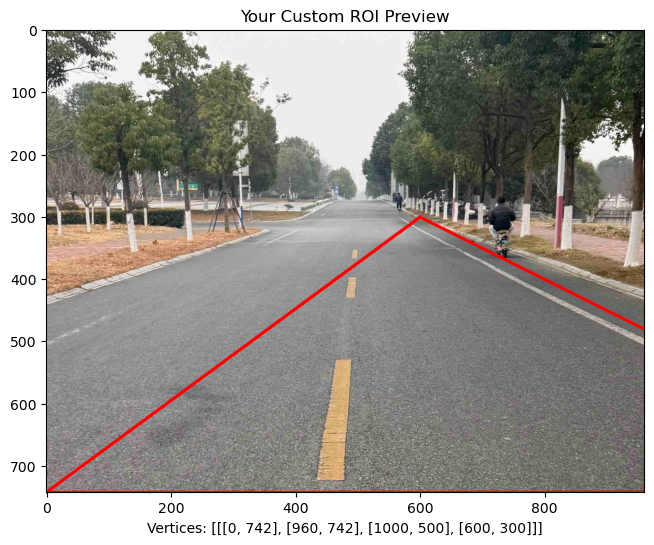

In [41]:
# --- 1. 在这里手动设定你的 ROI 顶点坐标 ---

# 获取图像的高度和宽度，方便参考
h, w = image.shape[:2]
print(f"图像尺寸: 宽度={w}, 高度={h}")

# 设定四个顶点的坐标 (x, y)
# 你需要修改下面这四个点的数值
# 提示：通常，底部的两个点会贴着图像的底边。关键是调整上面两个点的位置来匹配车道的消失点。
bottom_left = (0, h)          # 点1: 图像左下角
bottom_right = (w, h)         # 点2: 图像右下角
top_right = (1000, 500)        # 点3: 梯形右上角 (需要你根据图像调整)
top_left = (600, 300)         # 点4: 梯形左上角 (需要你根据图像调整)

# 将这四个点组合成OpenCV需要的格式
# 注意：数组内的顺序是 [bottom_left, bottom_right, top_right, top_left]
# cv2.fillPoly 会自动将它们连接成一个封闭的多边形
vertices = np.array([
    [bottom_left, bottom_right, top_right, top_left]
], dtype=np.int32)


# --- 2. 可视化你设定的 ROI 区域 ---
# 为了不影响原始图像，我们先复制一个副本
roi_preview = image.copy()

# 在副本上绘制你定义的多边形
# isClosed=True 表示将所有点连成一个封闭的形状
# color=(255, 0, 0) 是红色的线，thickness=3 让线更粗更显眼
cv2.polylines(roi_preview, vertices, isClosed=True, color=(255, 0, 0), thickness=3)

# 使用 Matplotlib 显示预览图像
plt.figure(figsize=(10, 6))
plt.imshow(roi_preview)
plt.title("Your Custom ROI Preview")
plt.xlabel(f"Vertices: {vertices.tolist()}") # 将顶点坐标显示在x轴标签上，方便查看
plt.axis('on') # 显示坐标轴，方便微调
plt.show()